## Protein Embeddings Manipulation

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt

from protera_stability.data import ProteinStabilityDataset

data_path = Path("../data") 

!ls $data_path

dtm_Thermonuclease.h5	    fireprotdb_results.csv  tm_fireprot.h5
embeddings_tm_fireprot.pkl  stability_fireprot.h5   tm_Thermonuclease.h5


### Get Dataset

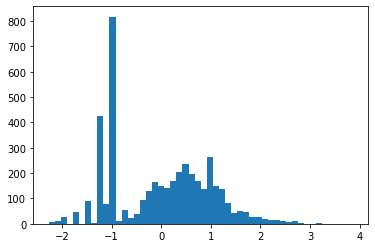

Number of observations: 4338


In [2]:
train_set = ProteinStabilityDataset(proteins_path=data_path / "tm_fireprot.h5")

plt.hist(train_set.y, bins=50)
plt.show()

print("Number of observations:", len(train_set))

## Dimensionality Reduction

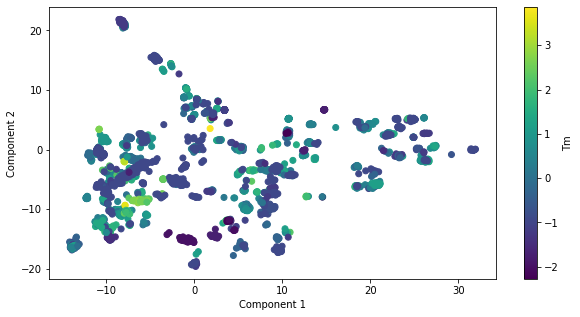

In [3]:
from protera_stability.utils.decomposition import dim_reduction
from sklearn.model_selection import train_test_split

X = dim_reduction(train_set.X, train_set.y, n_components=32, plot_viz=True, prefix="Tm")
y = train_set.y

X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=123)

## Modelling

### Grid Search

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge

from sklearn.metrics import r2_score


reg = Ridge(alpha=1e2)
reg.fit(X_train, y_train)

print("Linear Regression R2", reg.score(X_valid, y_valid))

scoring = "r2"
score = r2_score
models = {
    "RandomForest": {
        "model": RandomForestRegressor(),
        "params": {
            "n_estimators": [50, 100, 200],
            "max_depth": [None, 100],
            "criterion": ["mse", "mae"]
        },
    },
    "SVR": {
        "model": SVR(),
        "params": {
            "C": [0.1, 1.0, 10.0],
            "kernel": ["linear", "poly", "rbf", "sigmoid"],
            "degree": [3],
            "gamma": ["scale"],
        },
    },
    "MLP": {
        "model": MLPRegressor(),
        "params": {
            "hidden_layer_sizes": [(100,), (100, 100), (1024, 1024)],
            "activation": ["tanh", "relu"],
            "solver": ["sgd", "adam"],
        },
    },
}

Linear Regression R2 0.4375886989904838


In [5]:
import numpy as np

hidden_layer_sizes = [(int(x),int(y),int(z)) for x in np.logspace(start = 0, stop = 4, num = 10) for y in np.logspace(start = 0, stop = 4, num = 10) for z in np.logspace(start = 0, stop = 4, num = 10)]
hidden_layer_sizes.extend((int(x),int(y)) for x in np.logspace(start = 0, stop = 4, num = 15) for y in np.logspace(start = 0, stop = 4, num = 15))
hidden_layer_sizes.extend((int(x),) for x in np.logspace(start = 1, stop = 4, num = 100))

hidden_layer_sizes;

In [11]:
import scipy.stats as stats
from sklearn.utils.fixes import loguniform


models = {
    "RandomForest": {
        "model": RandomForestRegressor(),
        "params": {
            "n_estimators": stats.randint(10, 200),
            "max_depth": stats.randint(10, 500),
            "criterion": ["mse", "mae"]
        },
    },
    "SVR": {
        "model": SVR(),
        "params": {
            "C": loguniform(0.01, 20),
            "kernel": ["linear", "poly", "rbf", "sigmoid"],
            "degree": stats.randint(1, 20),
            "gamma": ["scale"],
        },
    },
    "MLP": {
        "model": MLPRegressor(),
        "params": {
            "hidden_layer_sizes": hidden_layer_sizes,
            "alpha" : loguniform(0.0001, 10),
            "activation": ["tanh", "relu"],
            "learning_rate_init": loguniform(0.0001, 0.1),
            "learning_rate": ['constant', 'invscaling', 'adaptive'],
            "solver": ["sgd", "adam", "lbfgs"],
        },
    },
}


In [12]:
from protera_stability.utils import perform_search

results = []
for name, model in models.items():
    search = perform_search(
        X_train,
        y_train,
        model["model"],
        model["params"],
        name,
        X_test=X_valid,
        y_test=y_valid,
        save_dir="./models",
        prefix="tm",
        strategy="random",
        n_jobs=12,
        verbose=True,
    )

    results.append(search)

Fitting model RandomForest...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


### Grid Search Results

#### Tm stability:

```
============
Fitting model RandomForest...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
RandomForest best R2: 0.6704531536748043
Best params: {'criterion': 'mse', 'max_depth': None, 'n_estimators': 100}
Test R2: 0.7276337475414528
============
============
Fitting model SVR...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
SVR best R2: 0.608712755496776
Best params: {'C': 10.0, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}
Test R2: 0.6525848043012554
============
============
Fitting model MLP...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
MLP best R2: 0.6382239118135511
Best params: {'activation': 'tanh', 'hidden_layer_sizes': (100, 100), 'solver': 'adam'}
Test R2: 0.687866803720006
============
```

In [ ]:
from joblib import dump

mlp = MLPRegressor(**{'activation': 'tanh', 'hidden_layer_sizes': (100, 100), 'solver': 'adam', "max_iter": 1000})

n = 1
for i in range(0, len(X_train), n):
    mlp.partial_fit(X_train[i:i+n], y_train[i:i+n])

mlp.fit(X, y)

print(mlp.score(X_valid, y_valid))
dump(mlp, f"./models/best_MLP_tm.joblib")

#### ddG stability: 

```
============
Fitting model RandomForest...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
RandomForest best R2: 0.30075493109476537
Best params: {'criterion': 'mse', 'max_depth': None, 'n_estimators': 200}
Test R2: 0.3753962076272399
============
============
Fitting model SVR...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
SVR best R2: 0.12765304242715786
Best params: {'C': 10.0, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}
Test R2: 0.13152081318954656
============
============
Fitting model MLP...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
MLP best R2: 0.17386091253619818
Best params: {'activation': 'tanh', 'hidden_layer_sizes': (100, 100), 'solver': 'adam'}
Test R2: 0.20536092750608248
============
```

### Bayes Search

In [ ]:
models = {
    "RandomForest": {
        "model": RandomForestRegressor(),
        "params": {
            "n_estimators": (50, 500, 'uniform'),
            "max_depth": (50, 500, 'uniform'),
            "criterion": ["mse", "mae"]
        },
    },
    "SVR": {
        "model": SVR(),
        "params": {
            "C": (1e-6, 1e+6, 'log-uniform'),
            "kernel": ["linear", "poly", "rbf", "sigmoid"],
            "degree": (1, 8),
            "gamma": ["scale", "auto"],
        },
    },
    "MLP": {
        "model": MLPRegressor(),
        "params": {
            "hidden_layer_sizes": [(10,), (100,), (100, 100), (1024, 1024)],
            "activation": ["tanh", "relu"],
            "solver": ["sgd", "adam"],
            "alpha": (1e-6, 1e-1, "log-uniform"),
            'learning_rate': ["constant", "adaptative"],
            "learning_rate_init": (1e-5, 1e-1, "log-uniform"),
        },
    },
}

In [ ]:
from protera_stability.utils import perform_search

results = []
# for name, model in models.items():
    # search = perform_search(
    #     X_train,
    #     y_train,
    #     model["model"],
    #     model["params"],
    #     name,
    #     X_test=X_valid,
    #     y_test=y_valid,
    #     strategy="bayes",
    #     save_dir="./models-bayes",
    #     n_jobs=15,
    # )

    # results.append(search)

### Ensemble: Tm Stability

In [ ]:
from sklearn.ensemble import VotingRegressor

reg1 = RandomForestRegressor(**{'criterion': 'mse', 'max_depth': None, 'n_estimators': 200})
reg2 = SVR(**{'C': 10.0, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'})
reg3 = MLPRegressor(**{'activation': 'tanh', 'hidden_layer_sizes': (100, 100), 'solver': 'adam'})
reg4 = Ridge(alpha=1e2)

ereg = VotingRegressor(
    estimators=
        [
            ('rf', reg1), 
            ('svr', reg2), 
            ('mlp', reg3),
            ('ridge', reg4)
        ],
    weights=[0.5, 0.2, 0.2, 0.1]
)

ereg.fit(X=X_train, y=y_train)
ereg.score(X_valid, y_valid)

In [ ]:
from joblib import dump
dump(ereg, "./models/ensemble_tm.joblib")